# 手动编写一个简单的RNN循环神经网络

## RNN的几种结构
循环神经网络（Recurrent Neural Network）是一种带有记忆功能的神经网络，广泛应用于自然语言处理、机器翻译、时间序列预测等与时序有关的任务中。与前馈神经网络只关心当前时刻的输入不同，循环神经网络的输出不仅取决于当前时刻的输入，还取决于上一个时刻的隐层状态，同时它还会把当前时刻的状态传递到下一个时刻，如此循环。RNN根据输入输出序列的形式可以分为一对多，多对一，多对多等不同结构种类。
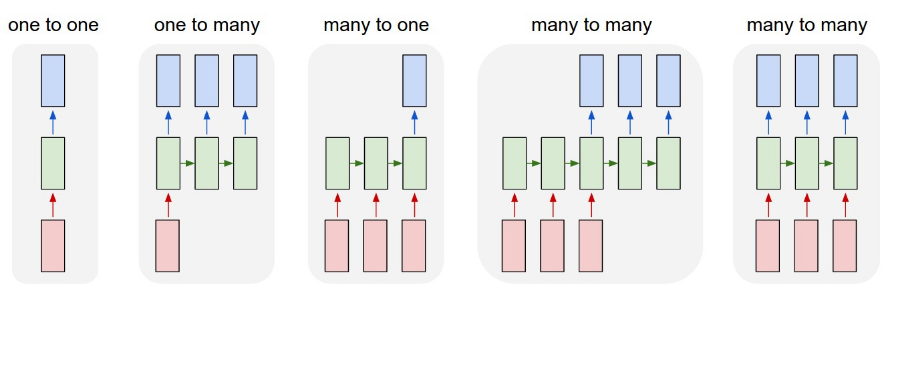
一对一：其实就是普通的前馈神经网络，并没有所谓的循环。

一对多：一个输入，输出一段序列，比如图像标题描述，输入一个图像，检测其中的多个物体并一一输出文字标题。

多对一：输入一段序列，对应一个输出，常用于分类，比如情绪检测中输入一段话，输出其情绪标签（正面或者负面）。

多对多：输入和输出都是一段序列，又分为两种，一种输出是非同步的，如机器翻译输入一段英语的句子翻译成中文输出。另一种是同步的，即序列的每一个输入同时对应一个输出，比如语言模型中为句子中的每一个词预测下一个词。

这里先总结一下RNN的训练过程和代码结构，再用语言模型（多对多）和时间序列预测（多对一）两个例子看看它是怎么工作的。

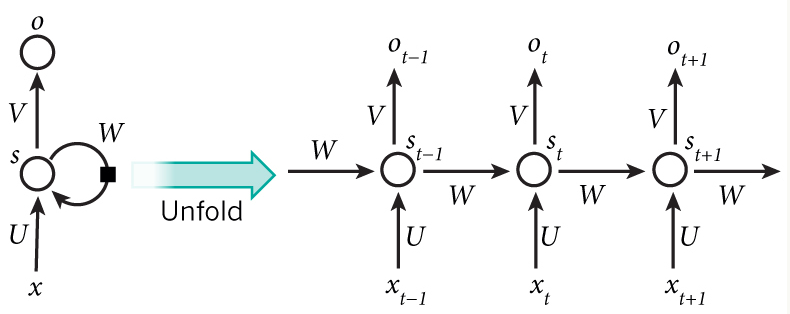
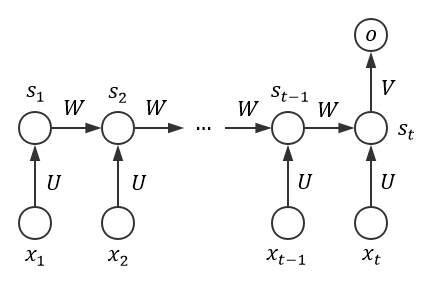

## BPTT算法
先看一下RNN的网络结构，上面的图中，x是一个输入向量，s是隐层的状态（也即隐层神经元的值），o是网络的输出向量。U、W、V分别是输入层与隐层、隐层与下一时刻隐层、隐层与输出层之间的权重矩阵。把RNN在时间上展开就得到了右边（多对多）或者下边（多对一）的形式。假如输入向量为m维，隐层有h个神经元，输出是一个n维的向量的话，上面各个向量（或矩阵）的维度为：$x\in \mathbb{R}^{m},   s\in \mathbb{R}^{h},   o\in \mathbb{R}^{n},   U\in \mathbb{R}^{h\times m},   W\in \mathbb{R}^{h\times h},   V\in \mathbb{R}^{n\times h}$。

在创建RNN_Net类的时候，需要设置各个层的维度，并对权重矩阵进行初始化。
### 前向计算
RNN的前向计算公式如下：
$$o_t = g(Vs_t)$$
$$s_t = f(Ux_t + Ws_{t-1})$$
g、f分别为输出层和隐层的激活函数。一般隐层的激活函数为tanh函数，输出层为softmax函数（用于分类）或者线性激活函数（用于回归），也可以用其它的激活函数比如sigmoid。
我们定义一个feedforward方法利用上面的公式进行前向计算，循环的次数等于输入序列的长度（不是输入向量的维度！输入序列包含一组输入向量）。同时需要记录每个时刻的隐层状态用于后续的梯度计算。
### 损失函数
计算误差项前要先选取损失函数，对于分类问题选择交叉熵损失函数（搭配softmax激活函数），
$$L(y,o) = -\frac{1}{N} \sum_{n\in N}y_nlog~o_n$$
在回归问题里用均方差损失函数（搭配线性或者sigmoid激活函数）。
$$L(y,o) = \frac{1}{N} \sum_{n\in N}(y_n-o_n)^2$$
我们定义了calc_loss方法计算单个样本损失，calc_total_loss方法计算整个训练集的损失。
### BPTT
首先计算输出层的误差项。这里我们定义一个中间的变量 $a = Vs_t$，即输出层通过激活函数前的值。损失函数对其求导可得：
$$ \delta_{out} = \frac{\partial L}{\partial o}\frac{\partial o}{\partial a} $$
其中 $\frac{\partial L}{\partial o}$ 一项当损失函数为均方差时为 $-2~(y - o)$，$\frac{\partial o}{\partial a} $一项为$(1-o) o$（激活函数为sigmoid）或者 1（激活函数为线性）。

当损失函数为交叉熵并且激活函数为softmax时误差项更为简洁 $\delta_{out} = o - y $ 。

接下来分别求出三个权值矩阵的更新公式（详细推导过程[参考这里](https://blog.csdn.net/wjc1182511338/article/details/79191099)）：

V最简单，因为它只与最后一个时刻的隐层状态有关，直接求导即可，不需要随时间传递。
$$\frac{\partial L_t}{\partial V} = \frac{\partial L_t}{\partial o_t}\frac{\partial o_t}{\partial a_t}\frac{\partial a_t}{\partial V} = \delta_{out} \otimes s_t$$

对于U和W，误差会沿着时间反向传播，如下图：
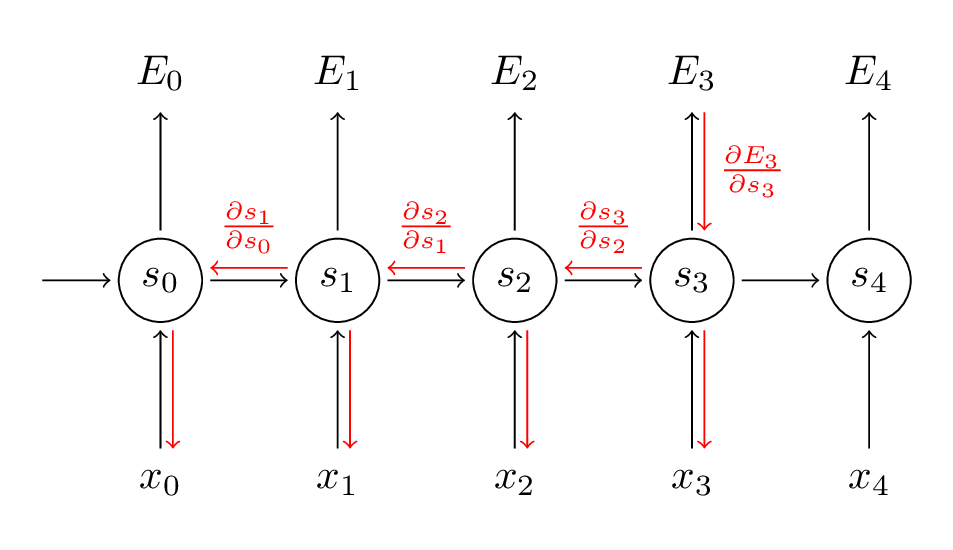
$$\frac{\partial L_t}{\partial W_{ij}} = \sum_{k}\sum_{l}\sum_{m}\frac{\partial L_t}{\partial o_{t_k}}\frac{\partial o_{t_k}}{\partial a_{t_l}}\frac{\partial a_{t_l}}{\partial s_{t_m}}\frac{\partial s_{t_m}}{\partial W_{ij}} = \sum_{l} \left \{ \delta_{t_l} \sum_{m} \left [ V_{lm} \sum_{r=0}^{t} ( \frac{\partial s_{t_m}}{\partial s_{r_n}} \frac{\partial s_{r_n}}{\partial W_{ij}} ) \right ] \right \} $$
$$\frac{\partial L_t}{\partial U_{ij}} = \sum_{k}\sum_{l}\sum_{m}\frac{\partial L_t}{\partial o_{t_k}}\frac{\partial o_{t_k}}{\partial a_{t_l}}\frac{\partial a_{t_l}}{\partial s_{t_m}}\frac{\partial s_{t_m}}{\partial U_{ij}} = (1 - s_{t_i}^2)~x_{t_j} \sum_{l} \left \{ \delta_{t_l} V_{li} \right \} $$

注意：隐层激活函数为tanh，而tanh的导数为 $\frac{\partial }{\partial x}tanh(x) = 1 - tanh^2(x)$

最后为了防止梯度爆炸或梯度消失，需要定义一个bptt_truncate参数，当反向传播的层数（时间步数）超过这个值便不再继续计算。BPTT算法的代码参考了
[DENNY BRITZ的博客](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
class RNN_Net:
    def __init__(self, num_inputs, num_hidden, num_outputs, bptt_truncate=4, loss_type='Cross_Entropy', 
                 activation='softmax', structure_type='many_to_many'):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.bptt_truncate = bptt_truncate
        # Xavier initialization
        self.U = np.random.randn(num_hidden, num_inputs) / np.sqrt(num_inputs)
        self.W = np.random.randn(num_hidden, num_hidden) / np.sqrt(num_hidden)
        self.V = np.random.randn(num_outputs, num_hidden) / np.sqrt(num_hidden)
        self.loss_type = loss_type
        self.activation = activation
        self.structure_type = structure_type
        self.shuffle = False

    def feedforward(self, x):
        # The total number of time steps
        T = len(x)
        # During forward propagation we save all hidden states in s because need them later.
        # We add one additional element for the initial hidden, which we set to 0
        s = np.zeros((T + 1, self.num_hidden))
        s[-1] = np.zeros(self.num_hidden)
        # feedforward for many to one structure
        if self.structure_type == 'many_to_one':
            o = np.zeros((1, self.num_outputs))
            for t in np.arange(T):
                s[t] = np.tanh(self.U.dot(x[t]) + self.W.dot(s[t-1]))
            if self.activation == 'sigmoid':
                o = self.sigmoid(self.V.dot(s[T-1]))
            if self.activation == 'softmax':
                o = self.softmax(self.V.dot(s[T-1]))
            if self.activation == 'linear':
                o = self.V.dot(s[T-1])
        # feedforward for many to many structure
        if self.structure_type == 'many_to_many':
            o = np.zeros((T, self.num_outputs))
            # For each time step...
            for t in np.arange(T):
                s[t] = np.tanh(self.U.dot(x[t]) + self.W.dot(s[t-1]))
                if self.activation == 'sigmoid':
                    o[t] = self.sigmoid(self.V.dot(s[t]))
                if self.activation == 'softmax':
                    o[t] = self.softmax(self.V.dot(s[t]))
                if self.activation == 'linear':
                    o[t] = self.V.dot(s[t])
        return o, s
    
    def calc_loss(self, x, y):
        o, s = self.feedforward(x)
        loss = 0.0
        if self.loss_type == 'MSE':
            loss += ((y - o)**2).sum()
        if self.loss_type == 'Cross_Entropy':
            loss += -np.sum(np.log(o) * y)
        return loss / len(y)
    
    def calc_total_loss(self, data, labels):
        loss = 0.0
        for i in range(len(data)):
            loss += self.calc_loss(data[i], labels[i])
        return loss / len(data)
    
    def output_gradient(self, o, y):
        if self.loss_type == 'MSE':
            if self.activation == 'sigmoid':
                g = -2 * (y - o) * (1 - o) * o
            if self.activation == 'linear':
                g = -2 * (y - o)
        if self.loss_type == 'Cross_Entropy':
            g = o - y
        return g
    
    def bptt(self, x, y):
        T = len(y)
        # Perform forward propagation
        o, s = self.feedforward(x)
        # We accumulate the gradients in these variables
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        delta_o = self.output_gradient(o, y)
        # For each output backwards...
        for t in np.arange(T)[::-1]:
            dLdV += np.outer(delta_o[t], s[t].T)
            # Initial delta calculation
            delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
                # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
                dLdW += np.outer(delta_t, s[bptt_step-1])              
                dLdU += np.outer(delta_t, x[bptt_step])
                # Update delta for next step
                delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
        return dLdU, dLdV, dLdW
        
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def softmax(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)
    
    def train_sgd(self, data, labels, learning_rate=0.1, nepoch=500):
        # We keep track of the losses so we can plot them later
        losses = []
        for epoch in range(nepoch):
            loss = self.calc_total_loss(data, labels)
            losses.append(loss)
            # For each training example...
            index = np.arange(len(training_labels))
            if self.shuffle:
                np.random.shuffle(index)
            for i in index:
                dLdU, dLdV, dLdW = self.bptt(data[i], labels[i])
                self.U -= learning_rate * dLdU
                self.V -= learning_rate * dLdV
                self.W -= learning_rate * dLdW
        return losses

## 多对一实验（预测国际航班乘客数量）

本质上是一个回归问题，我们需要根据过去n个月的乘客数量来预测下一个月的乘客数量。
$$ x_{t+1} = f(x_t, x_{t-1}, ... , x_{t-n}) $$
## 数据准备
这里我们使用某航空公司从1949年1月至1960年12月的国际航班乘客数数据[下载链接](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line)。使用pandas库可以方便地读取csv格式数据并查看。

In [3]:
dataset = pd.read_csv("international-airline-passengers.csv")
dataset.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


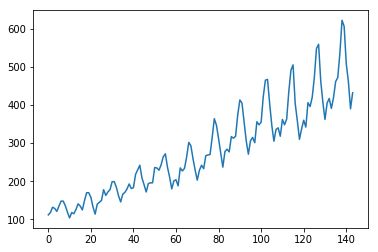

In [4]:
# 由于月份是连续的，我们不需要这一列数据，只需读取乘客数这一列，转换成数列形式并去掉最后一行（最后一行为NaN值）
passengers = dataset.as_matrix(columns=dataset.columns[1:2])[:-1]
plt.plot(passengers)
plt.show()

从上面的曲线图可以看到乘客数量随月份波动，并且有逐年增长的趋势。接下来我们需要将数据归一化以消除量纲的影响，提升数据训练稳定性。尤其是当我们在输出层用sigmoid函数作为激活函数时，需要将数据归一化到[0,1]区间内。这里我们采用MinMax归一化方法，sklearn里有现成的归一化工具，自己实现起来也非常简单。数据将被分为两部分，一部分用来训练，另一部分用来测试，两者比例为2:1。

In [5]:
# 数据归一化到[0, 1]区间内
scaler = MinMaxScaler(feature_range=(0, 1))
X_std = scaler.fit_transform(passengers)
train_size = int(len(X_std) * 2 / 3)
test_size = len(X_std) - train_size
X_train = X_std[:train_size]
X_test = X_std[-test_size:]

有了训练和测试数据，还需要生成对应的标签。对于这里的时间序列预测问题，标签生成非常简单，把下一个时刻的值作为当前样本的标签即可。这里定义了一个lookback参数，即我们需要多少个过去值来预测下一个时刻的值。这个参数也决定循环神经网络“循环”的次数，比如当 lookback=3 的时候，我们要预测4月的乘客数，就需要将1、2、3月的乘客数作为输入序列。

In [6]:
def create_dataset(raw_data, lookback=1):
    X, Y = [], []
    for i in range(0, len(raw_data)-1-lookback):
        X.append(np.vstack(raw_data[i:(i+lookback), 0]))
        Y.append(np.vstack(raw_data[(i+lookback):(i+1+lookback), 0]))
    return np.array(X), np.array(Y)

lookback = 3
training_set, training_labels = create_dataset(X_train, lookback)
test_set, test_labels = create_dataset(X_test, lookback)

数据准备完毕，现在可以开始创建并训练神经网络了。这里的输入和输出都是数值标量，所以神经网络的输入和输出都是1维的，隐层的神经元数量可以自己尝试不同的数值。这里是一个回归问题，所以我们选择均方差作为损失函数，激活函数搭配线性或者sigmoid。在RNN_Net类中我们已经定义了一个train_sgd方法进行简单的随机梯度下降。保存每一个epoch的损失，打印出来可以看到损失曲线呈下降趋势，尤其是线性激活函数下降得很快。

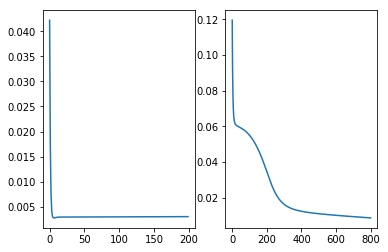

In [7]:
np.random.seed(7)
num_inputs = 1
num_outputs = 1
num_hidden = 10
model1 = RNN_Net(num_inputs, num_hidden, num_outputs, bptt_truncate=4, loss_type='MSE', 
                 activation='linear', structure_type='many_to_one')
losses1 = model1.train_sgd(training_set, training_labels, 0.01, 200)
model2 = RNN_Net(num_inputs, num_hidden, num_outputs, bptt_truncate=4, loss_type='MSE', 
                 activation='sigmoid', structure_type='many_to_one')
losses2 = model2.train_sgd(training_set, training_labels, 0.07, 800)
plt.subplot(121)
plt.plot(losses1)
plt.subplot(122)
plt.plot(losses2)
plt.show()

训练好网络后，用它在训练集和测试集上作出预测。不要忘了把输出转换回原始的量纲。

In [8]:
train_predict1, test_predict1 = [], []
for i in range(len(training_set)):
    o, _ = model1.feedforward(training_set[i])
    train_predict1.append(o)
train_predict1 = scaler.inverse_transform(train_predict1)
for i in range(len(test_set)):
    o, _ = model1.feedforward(test_set[i])
    test_predict1.append(o)
test_predict1 = scaler.inverse_transform(test_predict1)

train_predict2, test_predict2 = [], []
for i in range(len(training_set)):
    o, _ = model2.feedforward(training_set[i])
    train_predict2.append(o)
train_predict2 = scaler.inverse_transform(train_predict2)
for i in range(len(test_set)):
    o, _ = model2.feedforward(test_set[i])
    test_predict2.append(o)
test_predict2 = scaler.inverse_transform(test_predict2)

最后画出预测结果，和原始的乘客数曲线。可以看出网络确实得到了不错的预测结果，并且采用线性激活函数时的表现更好。

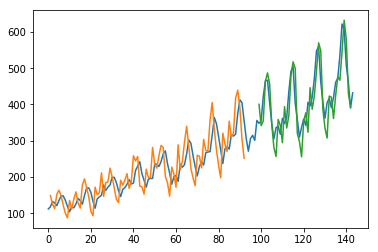

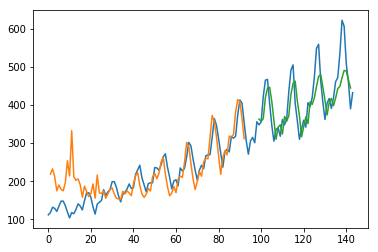

In [9]:
trainPredictPlot1 = np.empty_like(X_std)
trainPredictPlot1[:, :] = np.nan
trainPredictPlot1[1:len(train_predict1)+1, :] = train_predict1
# shift test predictions for plotting
testPredictPlot1 = np.empty_like(X_std)
testPredictPlot1[:, :] = np.nan
testPredictPlot1[len(train_predict1)+(lookback*2)+1:len(X_std)-1, :] = test_predict1
# plot baseline and predictions
plt.plot(passengers)
plt.plot(trainPredictPlot1)
plt.plot(testPredictPlot1)
plt.show()

trainPredictPlot2 = np.empty_like(X_std)
trainPredictPlot2[:, :] = np.nan
trainPredictPlot2[1:len(train_predict2)+1, :] = train_predict2
# shift test predictions for plotting
testPredictPlot2 = np.empty_like(X_std)
testPredictPlot2[:, :] = np.nan
testPredictPlot2[len(train_predict2)+(lookback*2)+1:len(X_std)-1, :] = test_predict2
# plot baseline and predictions
plt.plot(passengers)
plt.plot(trainPredictPlot2)
plt.plot(testPredictPlot2)
plt.show()

## 多对多实验（语言模型）

语言模型可以衡量一个句子出现的概率。假如我们有一个包含m个单词的句子，那么在语言模型下该句子的概率可以表示为：
$$P(w_1, w_2, \cdots ,w_m) = \prod_{i=1}^{m}P(w_i|w_1, \cdots, w_{i-1})$$

这个概率模型比较复杂，因为 $w_i$ 出现的条件概率取决于前面所有的单词，计算起来会非常麻烦。通常作马尔可夫假设，即$w_i$的条件概率只取决于前面(n - 1)个单词（n-gram）：
$$P(w_1, w_2, \cdots ,w_m) = \prod_{i=1}^{m}P(w_i|w_1, \cdots, w_{i-1}) = \prod_{i=1}^{m}P(w_i|w_{i-(n-1)}, \cdots, w_{i-1})$$

一般通过语料就可以估算出n-gram的概率：
$$P(w_2|w_1) = \frac{Count(w_1, w_2)}{Count(w_1)}, P(w_3|w_1,w_2) = \frac{Count(w_1, w_2, w_3)}{Count(w_1, w_2)}$$

这个语言模型不仅可以用来评价句子的好坏（比如机器翻译），也可以用来生成新的文本。

## 数据准备

在这里我的语料库选择了我最喜欢的作家王尔德的名著 ”The Picture of Dorian Gray“，文件下载自[Gutenberg Projekt](http://www.gutenberg.org)。读取txt文件后，用nltk包里的sent_tokenize析取句子。前三句以及索引6513后的句子都是与小说无关的版权等信息故去之。然后我们在每个句子前后加上一个'START'和'END'标签，这样可以学习到哪些词比较常用作句子的开头和结尾。最后用word_tokenize方法把句子拆分成一个个单词。

In [10]:
import nltk
import itertools

In [11]:
with open ('174.txt') as f:            
    text = f.read()
sent_text = nltk.sent_tokenize(text.lower())
sent_text = ['%s %s %s' % ('START', x, 'END') for x in sent_text[3:6513]]
tokenized_sentences = [nltk.word_tokenize(s) for s in sent_text]

接下来需要剔除那些非常罕见的词，因为这些词的训练样本太少一般很难学习到合适的概率表达。这里我们只选取出现频次最高的5000个单词作为语料库，并把其它的单词都替换成 'UNKNOWN'。

然后我们需要建立一个字典，为每一个单词分配一个独立的索引，这样我们的句子就能完全用数字来表达了。对于一个长度为n的句子，取第0到(n-1)个单词为训练集，第1到n个单词为其对应的标签。

除此之外，还需要把样本中的每一个数据转换成one-hot向量，才能最后用于神经网络中的向量运算。

In [13]:
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
corpus_size = 5000
corpus = word_freq.most_common(corpus_size-1)
index_to_word = [x[0] for x in corpus]
index_to_word.append('UNKNOWN')
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else 'UNKNOWN' for w in sent]
print("\nExample sentence after Pre-processing: '%s'" % tokenized_sentences[0])
 
# Create the training data
X_train_language = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
y_train_language = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

print('\nTraining data and test data sample:\n', X_train_language[0], '\n', y_train_language[0])

# Convert to one_hot vector
training_set_language = [np.eye(corpus_size)[np.array(x).reshape(-1)] for x in X_train_language]
training_labels_language = [np.eye(corpus_size)[np.array(x).reshape(-1)] for x in y_train_language]


Example sentence after Pre-processing: '['START', 'the', 'picture', 'of', 'dorian', 'gray', 'by', 'oscar', 'wilde', 'the', 'preface', 'the', 'artist', 'is', 'the', 'creator', 'of', 'beautiful', 'things', '.', 'END']'

Training data and test data sample:
 [0, 4, 167, 6, 36, 72, 62, 1910, 1911, 4, 3561, 4, 335, 20, 4, 3562, 6, 242, 95, 2] 
 [4, 167, 6, 36, 72, 62, 1910, 1911, 4, 3561, 4, 335, 20, 4, 3562, 6, 242, 95, 2, 1]


这里再创建一个RNN_Net，输入层和输出层由于使用了one_hot向量，维度均为5000。这个语言模型训练本质上是一个分类问题，即我们要在RNN输出的概率向量中找到概率最大的位置所对应的单词。所以损失函数需要用交叉熵，激活函数为softmax。由于语言模型的语料库一般都非常大，训练起来非常耗时，这里只训练了10个epoch，从损失曲线可以看出总的损失是在减少的。

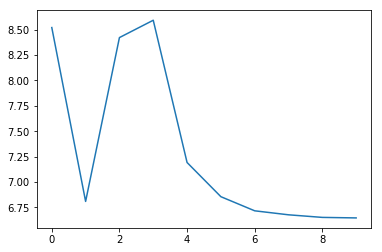

In [25]:
num_inputs = corpus_size
num_outputs = corpus_size
num_hidden = 100
model = RNN_Net(num_inputs, num_hidden, num_outputs, bptt_truncate=4, loss_type='Cross_Entropy', 
                 activation='softmax', structure_type='many_to_many')
losses = model.train_sgd(training_set_language, training_labels_language, 0.01, 10)
plt.plot(losses)
plt.show()